In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

2024-11-29 23:48:05.472382: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 23:48:05.570401: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 23:48:05.657461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732904285.807897    5112 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732904285.833632    5112 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 23:48:06.033694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [ ]:
# Load dataset
file_path = 'package_info.csv'
data = pd.read_csv(file_path)


# Remove unnecessary columns
data = data.drop(columns=['id', 'commit_hash'])

# Format timestamp
data['upload_time'] = pd.to_datetime(data['upload_time'])

# Sort within each package_id group based on upload_time
data = data.sort_values(['package_id', 'upload_time'])

# Group by 'package_id' and calculate upload_time_delta for each group
data['upload_time_delta'] = data.groupby('package_id')['upload_time'].transform(
    lambda x: (x - x.min()).dt.total_seconds()
)

# Drop the original upload_time column as it is no longer needed
data = data.drop(columns=['upload_time'])
data

,package_id,num_files,total_additions,total_deletions,links,avg_dir_depth,max_dir_depth,avg_file_size,median_file_size,total_size,has_executables,time_since_last_commit,dependency_count,was_suspicious_before,upload_time_delta
0,1,95,1209,0,36,5.0,7,820.0,402.0,77900,0,0,33,0.0,0.0
1,1,94,273,158,35,5.0,7,857.0,383.0,81415,0,61931,33,0.0,61931.0
2,1,94,15,4,34,5.0,7,861.0,356.0,77490,0,1105359,33,0.0,1167290.0
3,1,93,60,33,32,5.0,7,860.0,356.0,81700,0,363069,31,0.0,1530359.0
4,1,97,133,12,32,5.0,7,871.0,350.0,84487,0,2123597,31,0.0,3653956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93591,947,109,135,47,28,7.0,9,379.0,620.0,41311,0,2644628,71,0.0,125444863.0
93592,947,109,240,144,30,7.0,9,389.0,614.0,42401,0,968017,77,0.0,126412880.0
93593,947,109,347,217,31,7.0,9,339.0,600.0,38307,0,1312020,73,0.0,127724900.0
93594,947,112,6,0,30,7.0,9,339.0,589.0,33900,0,2571957,68,0.0,130296857.0


In [ ]:
# Prepare CNN data function
def prepare_cnn_data(data):
    grouped = data.groupby('package_id')
    X = []
    y = []
    
    for package_id, group in grouped:
        # Extract features and label
        features = group.drop(columns=['package_id', 'was_suspicious_before']).values
        print(features)
        label = group['was_suspicious_before'].iloc[0]  # Same label for all rows in a package
        
        X.append(features)
        y.append(label)
    
    # Find the maximum length of sequences (longest package_id group)
    max_timesteps = max(seq.shape[0] for seq in X)
    num_features = X[0].shape[1]  # Number of features (columns)
    
    # Pad sequences to ensure equal length
    X_padded = np.array([
        np.pad(seq, ((0, max_timesteps - seq.shape[0]), (0, 0)), mode='constant')
        for seq in X
    ])
    
    return np.array(X_padded), np.array(y)

# Assuming 'data' is your DataFrame
X, y = prepare_cnn_data(data)

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# One-hot encode the labels (for binary classification, this converts 0/1 to [1, 0] and [0, 1])
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Define the CNN model using Conv1D
model = Sequential([
    # First Conv1D layer
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),  # Reduce dimensions
    Dropout(0.3),              # Dropout to prevent overfitting

    # Second Conv1D layer
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Flatten and dense layers for classification
    Flatten(),
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict on the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Output predictions
print("Predicted classes:", predicted_classes)


[[9.5000000e+01 1.2090000e+03 0.0000000e+00 ... 0.0000000e+00
  3.3000000e+01 0.0000000e+00]
 [9.4000000e+01 2.7300000e+02 1.5800000e+02 ... 6.1931000e+04
  3.3000000e+01 6.1931000e+04]
 [9.4000000e+01 1.5000000e+01 4.0000000e+00 ... 1.1053590e+06
  3.3000000e+01 1.1672900e+06]
 ...
 [6.8000000e+01 8.7000000e+01 1.1000000e+01 ... 1.2396820e+06
  2.0000000e+01 9.8110555e+07]
 [7.7000000e+01 4.0000000e+00 2.0000000e+00 ... 1.2480700e+06
  2.0000000e+01 9.9358625e+07]
 [8.1000000e+01 6.0000000e+01 9.0000000e+00 ... 8.2642000e+04
  2.0000000e+01 9.9441267e+07]]
[[7.00000000e+00 3.03200000e+03 0.00000000e+00 ... 0.00000000e+00
  4.70000000e+01 0.00000000e+00]
 [7.00000000e+00 2.23000000e+02 2.10000000e+01 ... 1.24836800e+06
  4.70000000e+01 1.24836800e+06]
 [7.00000000e+00 1.94000000e+02 1.13000000e+02 ... 1.44078000e+06
  4.60000000e+01 2.68914800e+06]
 ...
 [7.00000000e+00 2.48000000e+02 9.40000000e+01 ... 2.97980500e+06
  4.30000000e+01 1.42469343e+08]
 [7.00000000e+00 1.70000000e+01 3.0

In [ ]:
# Save the model
model.save('cnn_model.h5')

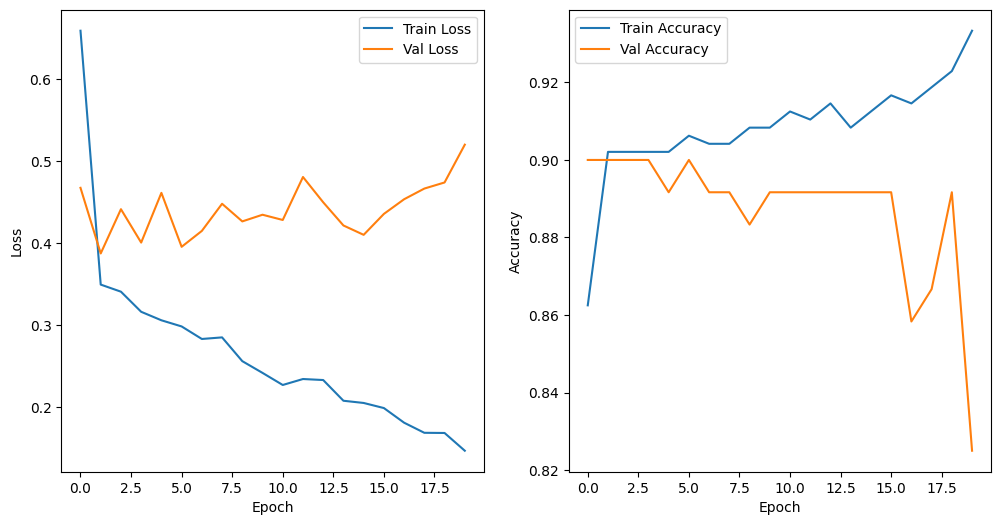

In [ ]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [42]:
# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test, axis=1)
print(y_test_original)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0]


In [43]:
# make confusion matrix for above test data and predicted data
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_original, predicted_classes)

array([[97, 11],
       [10,  2]])